In [1]:
import numpy
import TempoDetector
import Song
import numpy
import scipy.io.wavfile
from matplotlib import pyplot as plt

In [2]:
def PrepareDict(minBpm, maxBpm):
    dict = {}
    for bpm in range(minBpm, maxBpm):
        dict[bpm] = 0
    return dict


def DrawPlot(isDrawPlots, data, title, xAxis, yAxis, xData= 0):
    if isDrawPlots:
        if xData is 0:
            plt.plot(data)
        else:
            plt.plot(data, xData)
        plt.title(title)
        plt.xlabel(xAxis)
        plt.ylabel(yAxis)
        plt.show()    

In [3]:
def DrawFftPlot(isDrawPlots, data, title, max_freq):
    if isDrawPlots:
        L = len(data)
        H = abs(data/L)
        H = H[1:int(L/2+1)]
        f = max_freq* (numpy.arange(0,int(L/2)))/L
        
        plt.plot(f, H)
        plt.title(title)
        plt.xlabel("f[Hz]")
        plt.ylabel("|H(f)|")
        plt.xlim(0, max(f))
        plt.show()   

In [19]:
def DrawTimeCombFftPlot(isDrawPlots, data, title, max_freq):
    if isDrawPlots:
        L = len(data)
        H = abs(data/L)
        H = H[1:int(L/2+1)]
        f = max_freq* (numpy.arange(0,int(L/2)))/L
        
        plt.plot(f, H)
        plt.title(title)
        plt.xlabel("f[Hz]")
        plt.ylabel("|H(f)|")
        plt.xlim(0, 10)
        plt.show() 

In [5]:
def centerSample(signal, seconds):
    n = len(signal)
    index = 0

    max = numpy.max(signal)

    for i in range(0, n):
        if signal[i] > max*0.9:
            index = i
            break

    lastindex = seconds
    lastindex += index
    if lastindex > n:
        lastindex = n
    output = signal[index:int(lastindex)]
    return output

In [6]:
      class Song:
        name = "name"
        bpm = 120,
        filepath = "test"

        def __init__(self, name, bpm, filepath):
            self.name = name
            self.bpm = bpm
            self.filepath = filepath
        
        
    
band_limits = [0, 200, 400, 800, 1600, 3200]    
npulses = 10
minBpm = 60
maxBpm = 240
draw_plots = True

song = Song("8-i'll_pretend", 140, "songs\\rock\\8-i'll_pretend.wav")

In [7]:
def filterbank(signal, bandlimits, maxFreq):
    dft = numpy.fft.fft(signal)
    n = len(dft)
    nbands = len(bandlimits)
    bl = numpy.zeros(nbands, int)
    br = numpy.zeros(nbands, int)

    #   % Bring band scale from Hz to the points in our vectors
    for band in range(0, nbands - 1):
        bl[band] = numpy.floor(bandlimits[band] / maxFreq * n / 2) + 1
        br[band] = numpy.floor(bandlimits[band + 1] / maxFreq * n / 2)

    bl[0] = 0
    bl[nbands - 1] = numpy.floor(bandlimits[nbands - 1] / maxFreq * n / 2) + 1
    br[nbands - 1] = numpy.floor(n / 2)

    output = numpy.zeros([nbands, n], dtype=complex)

    # Create the frequency bands and put them in the vector output.
    for band in range(0, nbands):
        for hz in range(bl[band], br[band]):
            output[band, hz] = dft[hz]
        for hz in range(n - br[band], n - bl[band]):
            output[band, hz] = dft[hz]
        # output[int(bl[band]): int(br[band])][band] = dft[int(bl[band]): int(br[band])]
        # output[n + 1 - br[band]: n + 1 - bl[band], band] = dft[n + 1 - br[band]: n + 1 - bl[band]]

    output[1, 1] = 0
    return output

In [8]:
def readSong(filename):
    sample_freq, data = scipy.io.wavfile.read(filename)
    signal = numpy.frombuffer(data, numpy.int16)
    return signal, sample_freq

In [9]:
def hwindow(signal, winLength, bandlimits, maxFreq):
    n = len(signal[0])
    nbands = len(bandlimits)
    hannlen = winLength * 2 * maxFreq
    hann = numpy.zeros(n)
    wave = numpy.zeros([nbands, n], dtype=complex)
    output = numpy.zeros([nbands, n], dtype=complex)
    freq = numpy.zeros([nbands, n], dtype=complex)
    filtered = numpy.zeros([nbands, n], dtype=complex)

    # Create half-Hanning window.
    for a in range(1, int(hannlen)):
        hann[a] = (numpy.cos(a * numpy.pi / hannlen / 2)) ** 2

    # Take IFFT to transfrom to time domain.
    for band in range(0, nbands):
        wave[band] = numpy.real(numpy.fft.ifft(signal[band]))

    # Full - wave rectification in the time domain. And back to frequency with FFT.
    for band in range(0, nbands):
        for j in range(0, n):
            if wave[band, j] < 0:
                wave[band, j] = -wave[band, j]
        freq[band] = numpy.fft.fft(wave[band])

    # Convolving with half - Hanning same as multiplying in frequency.Multiply half - Hanning
    # FFT by signal FFT.Inverse transform to get output in the time domain.
    for band in range(0, nbands):
        filtered[band] = freq[band] * numpy.fft.fft(hann)
        output[band] = numpy.real(numpy.fft.ifft(filtered[band]))

    return output

In [10]:
def diffrect(signal, nbands=6):
    n = len(signal[0])
    output = numpy.zeros([nbands, n], dtype=complex)

    for band in range(0, nbands):
        for j in range(5, n):
            d = signal[band, j] - signal[band, j-1]
            if d > 0:
                output[band, j] = d;

    return output

In [11]:
def timecomb(signal, accuracy, minBpm, maxBpm, bandlimits, maxFreq, npulses, plot_dictionary):
    n = len(signal[0])
    nbands = len(bandlimits)
    dft = numpy.zeros([nbands, n], dtype=complex)

    if minBpm < 60:
        minBpm = 60

    if maxBpm > 240:
        maxBpm = 240

    # Get signal in frequency domain
    for band in range(0, nbands):
        dft[band] = numpy.fft.fft(signal[band])
        DrawFftPlot(True, dft[band], f"Band[{band}] DFT", maxFreq)

    # % Initialize max energy to zero
    maxe = 0
    for bpm in range(minBpm, maxBpm, accuracy):
        # % Initialize energy and filter to zero(s)
        e = 0
        fil = numpy.zeros(n)

        # Calculate the difference between peaks in the filter for a certain tempo
        nstep = numpy.floor(60 / bpm * maxFreq)
        percent_done = 100 * (bpm - minBpm) / (maxBpm - minBpm)
        print(percent_done)


        # Set every nstep samples of the filter to one
        for a in range(0, npulses):
            fil[a * int(nstep) + 1] = 1

        DrawPlot(True, fil, f"Timecomb bpm: {bpm}", "Sample/Time", "Amplitude")
        # Get the filter in the frequency domain
        dftfil = numpy.fft.fft(fil)
        DrawTimeCombFftPlot(True, dftfil, f"Signal DFT {bpm}", maxFreq)

        for band in range(0, nbands):
            x = (abs(dftfil * dft[band])) ** 2
            e = e + sum(x)

        plot_dictionary[bpm] = e
        # If greater than all previous energies, set current bpm to the bpm of the signal
        if e > maxe:
            sbpm = bpm
            maxe = e

    output = sbpm
    return output

In [12]:
def detectMetre(signal, tempo, bandlimits, maxFreq, npulses):
    n = len(signal[0])
    nbands = len(bandlimits)
    dft = numpy.zeros([nbands, n], dtype=complex)

    # Get signal in frequency domain
    for band in range(0, nbands):
        dft[band] = numpy.fft.fft(signal[band])

    DrawPlot(True, signal[1], "Signal[1]", "Sample/Time", "Amplitude")

    metres = {}
    metre, metre_dft = fourForth(tempo, n, maxFreq, npulses)
    metres[metre] = metre_dft
    metre, metre_dft = threeForth(tempo, n, maxFreq, npulses)
    metres[metre] = metre_dft
    # % Initialize max energy to zero
    maxe = 0
    for metrum in metres:
        # % Initialize energy and filter to zero(s)
        e = 0

        for band in range(0, nbands):
            x = (abs(metres[metrum] * dft[band])) ** 2
            e = e + sum(x)

        # If greater than all previous energies, set current bpm to the bpm of the signal
        if e > maxe:
            song_metre = metrum
            maxe = e

    output = song_metre
    return output


def fourForth(tempo, n, maxFreq, npulses):
    fil = numpy.zeros(n)
    nstep = numpy.floor(60 / tempo * maxFreq)
    index = 0
    bit = 0
    while index < n and bit <= npulses:
        value = 2
        if bit % 2 > 0:
            value = 1

        fil[int(index)] = value
        index += nstep
        bit += 1

    DrawPlot(True, fil, "4/4", "Sample/Time", "Amplitude")
    return "4/4", numpy.fft.fft(fil)


def threeForth(tempo, n, maxFreq, npulses):
    fil = numpy.zeros(n)
    nstep = numpy.floor(60 / tempo * maxFreq)  # every third bit
    index = 0
    bit = 0
    while index < n and bit <= npulses:
        value = 2
        if bit % 3 > 0:
            value = 1
        fil[int(index)] = value
        index += nstep
        bit += 1

    DrawPlot(True, fil, "3/4", "Sample/Time", "Amplitude")
    return "3/4", numpy.fft.fft(fil)

C:\Users\marek\Anaconda3\lib\site-packages\scipy\io\wavfile.py:273: WavFileWarning: Chunk (non-data) not understood, skipping it.
  WavFileWarning)


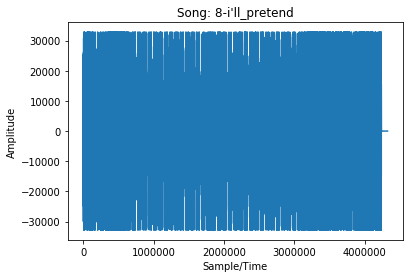

In [13]:
    signal, sample_freq = readSong(song.filepath)
    max_freq = sample_freq
    sample_length = npulses * max_freq
    seconds = sample_length * 4
    DrawPlot(draw_plots, signal, f"Song: {song.name}", "Sample/Time", "Amplitude")
    song_length = signal.size

    start = int(numpy.floor(song_length / 2 - seconds / 2))
    stop = int(numpy.floor(song_length / 2 + seconds / 2))
    if start < 0:
        start = 0
    if stop > song_length:
        stop = song_length

    sample = signal[start:stop]

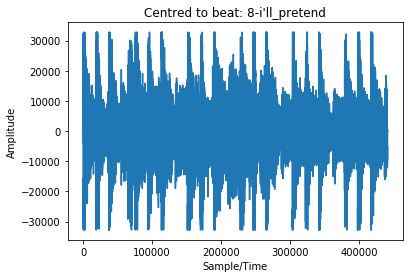

In [14]:
centred = centerSample(sample, sample_length)
DrawPlot(draw_plots, centred, f"Centred to beat: {song.name}", "Sample/Time", "Amplitude")

Filtering song {song.name}...


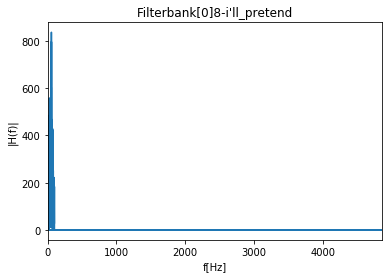

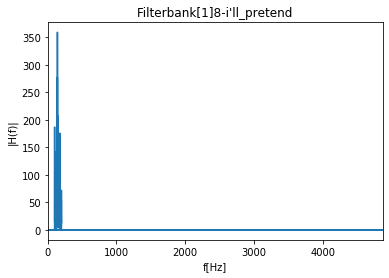

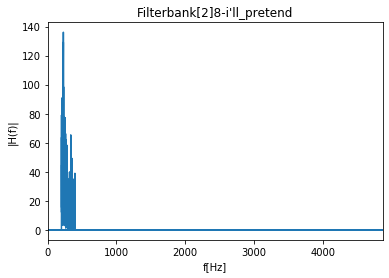

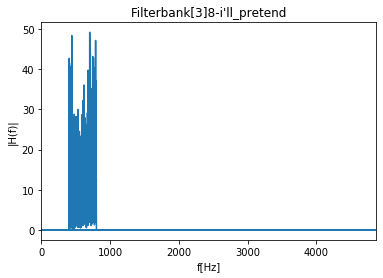

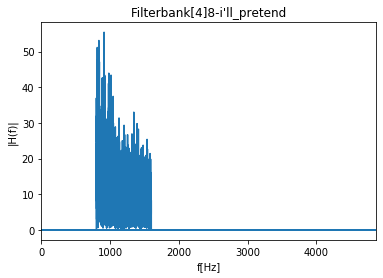

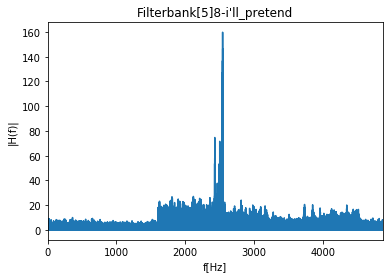

In [15]:
print('Filtering song {song.name}...')
fastFourier = filterbank(centred, band_limits, max_freq)
for i in range(0, len(band_limits)):
    DrawFftPlot(draw_plots, fastFourier[i], f"Filterbank[{i}]{song.name}", max_freq)

Windowing song 8-i'll_pretend...


C:\Users\marek\Anaconda3\lib\site-packages\numpy\core\numeric.py:538: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


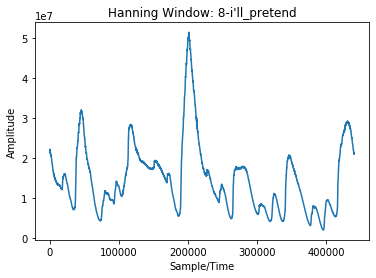

In [16]:
print(f'Windowing song {song.name}...')
hanningWindow = hwindow(fastFourier, 0.2, band_limits, max_freq)
DrawPlot(draw_plots, hanningWindow[1], f"Hanning Window: {song.name}", "Sample/Time", "Amplitude")

Differentiating song 8-i'll_pretend...


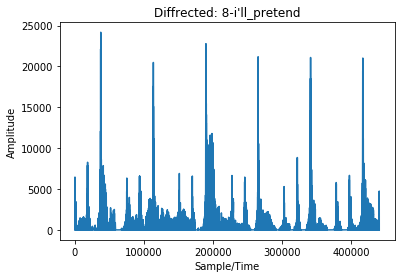

In [17]:
print(f'Differentiating song {song.name}...')
diffrected = diffrect(hanningWindow, len(band_limits))
DrawPlot(draw_plots, diffrected[1], f"Diffrected: {song.name}", "Sample/Time", "Amplitude")

CombFiltering song 8-i'll_pretend...


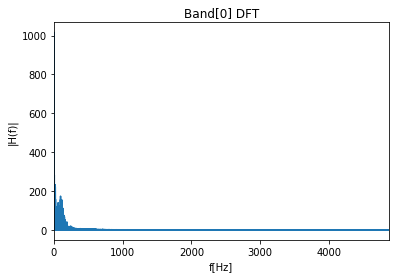

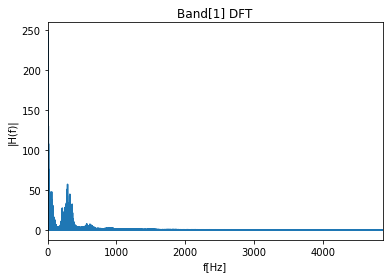

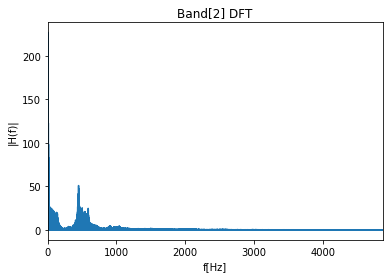

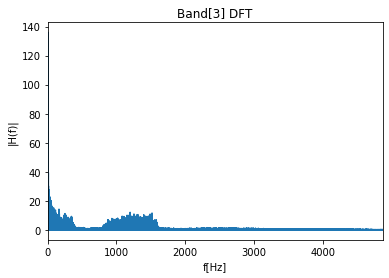

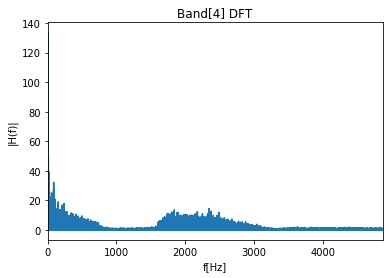

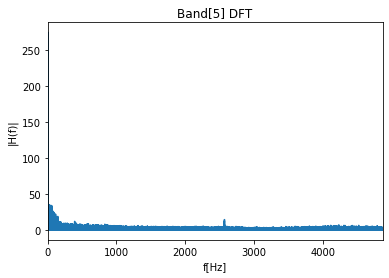

0.0


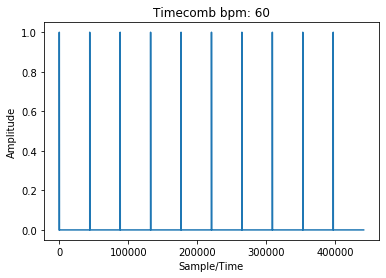

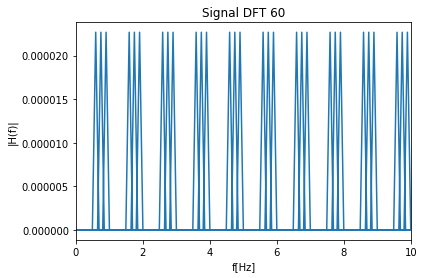

2.7777777777777777


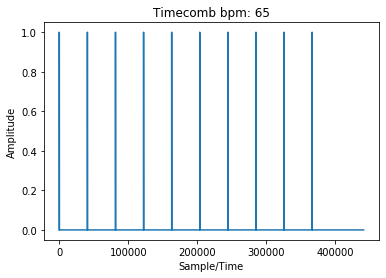

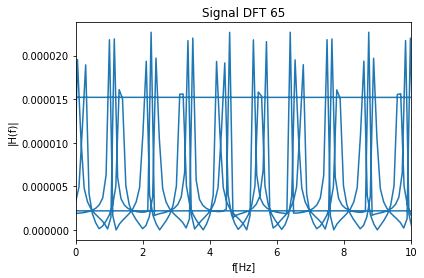

5.555555555555555


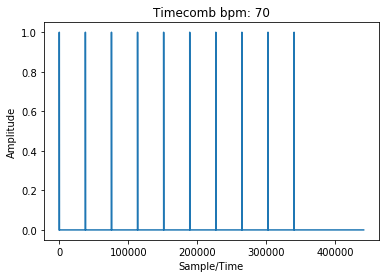

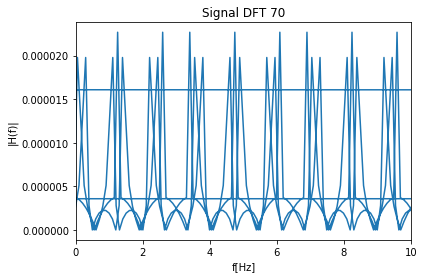

8.333333333333334


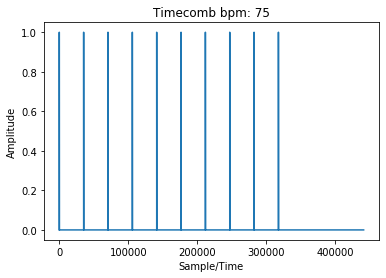

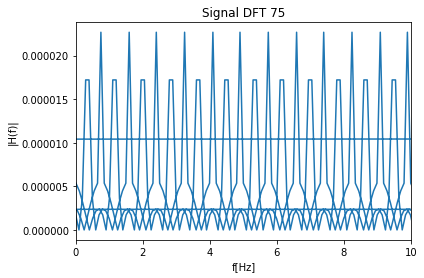

11.11111111111111


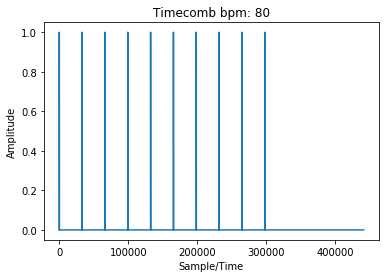

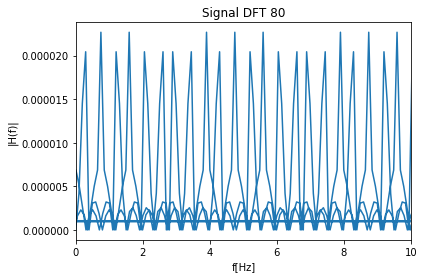

13.88888888888889


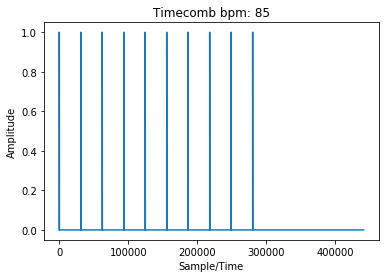

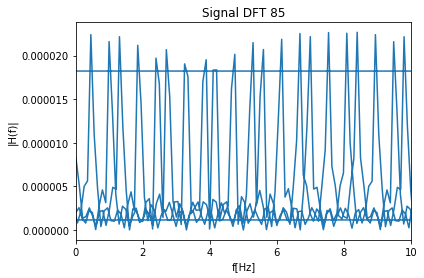

16.666666666666668


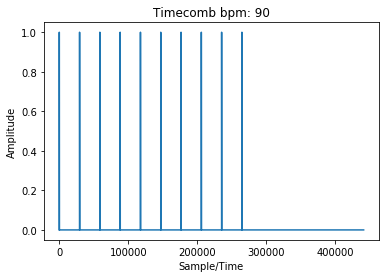

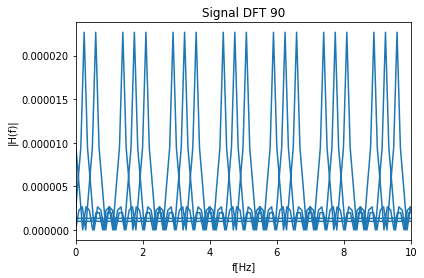

19.444444444444443


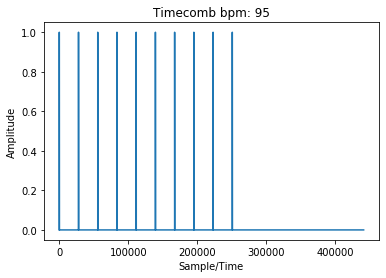

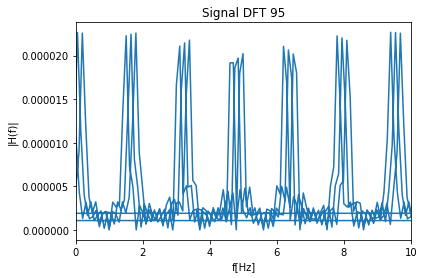

22.22222222222222


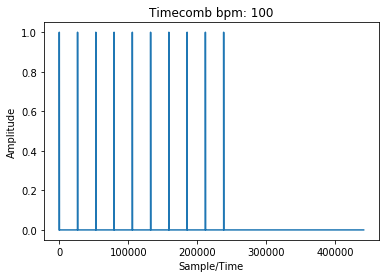

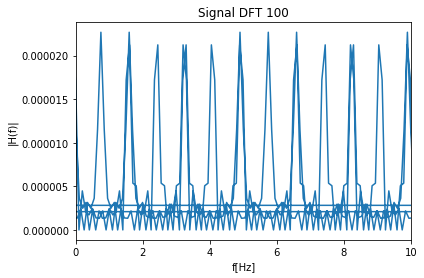

25.0


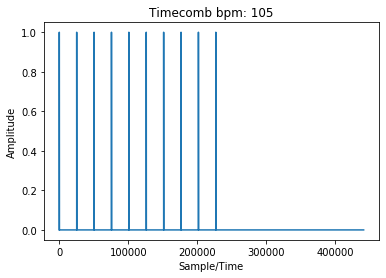

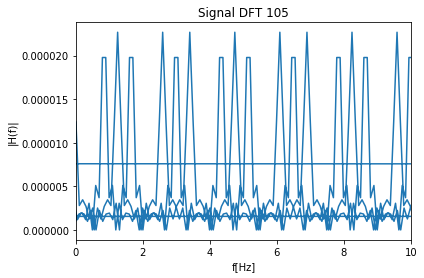

27.77777777777778


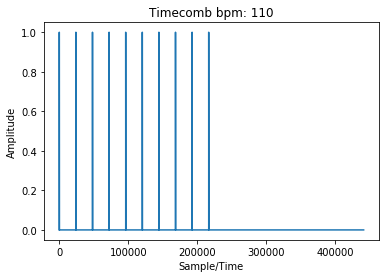

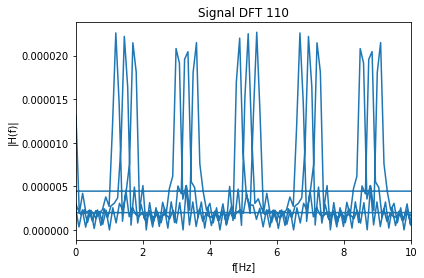

30.555555555555557


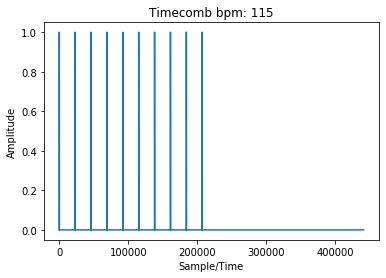

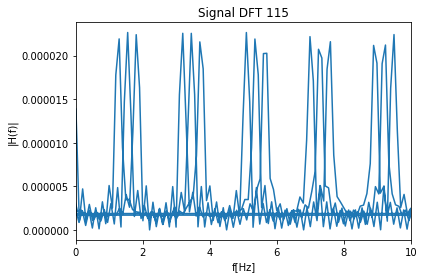

33.333333333333336


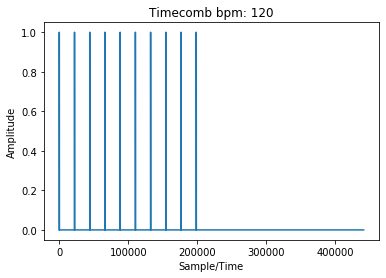

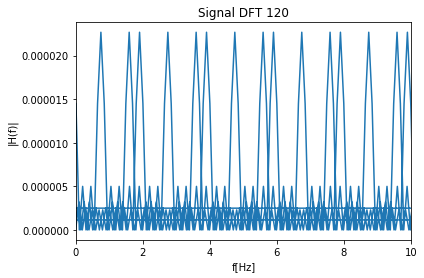

36.111111111111114


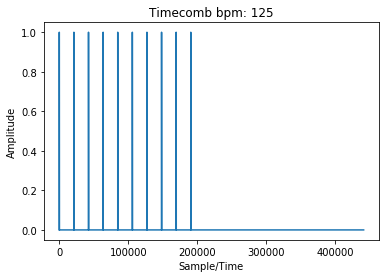

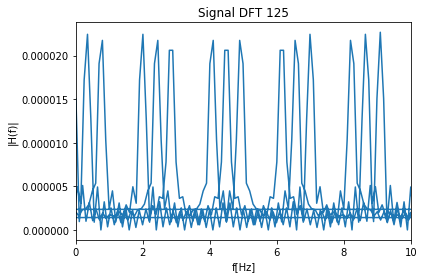

38.888888888888886


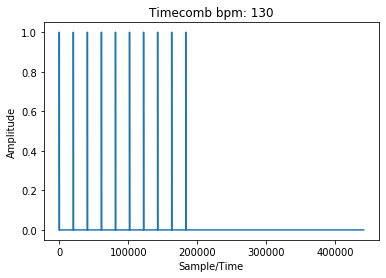

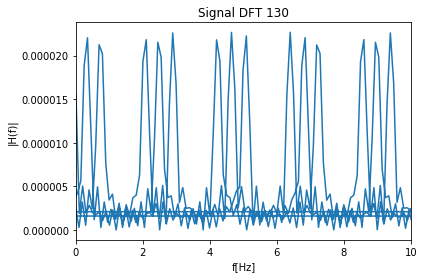

41.666666666666664


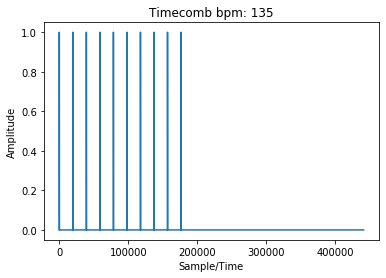

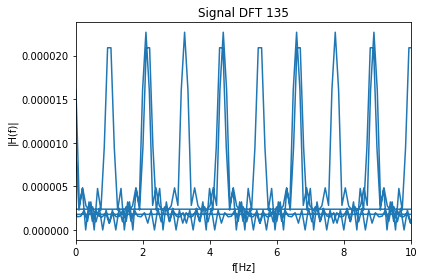

44.44444444444444


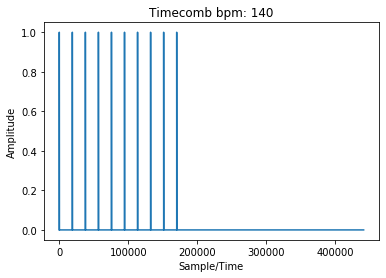

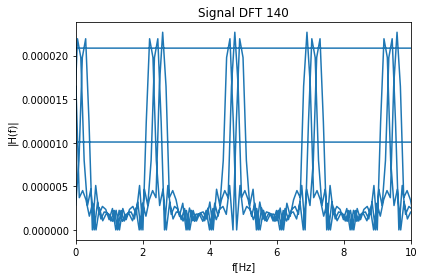

47.22222222222222


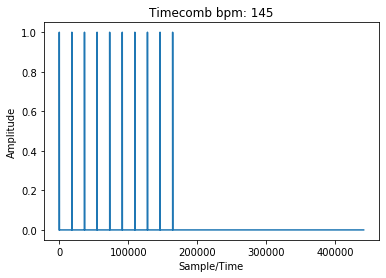

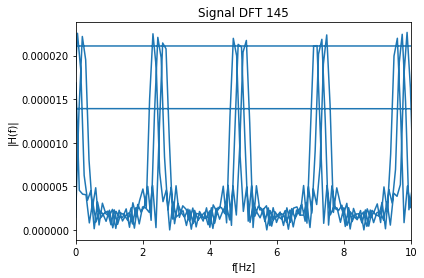

50.0


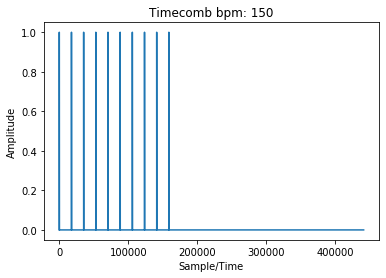

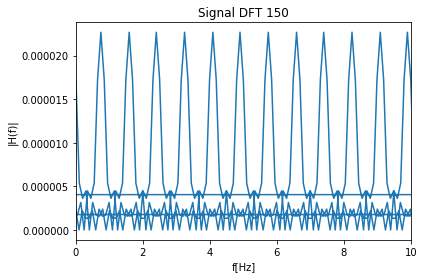

52.77777777777778


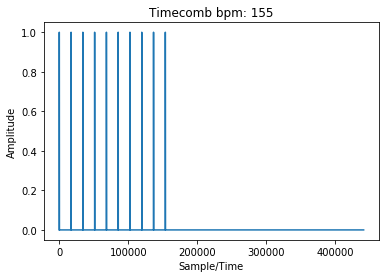

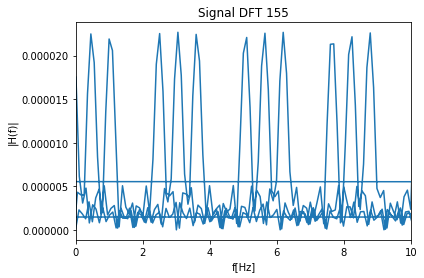

55.55555555555556


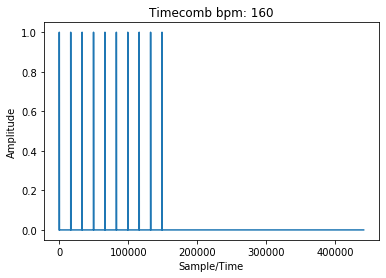

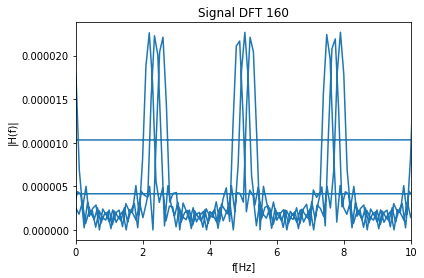

58.333333333333336


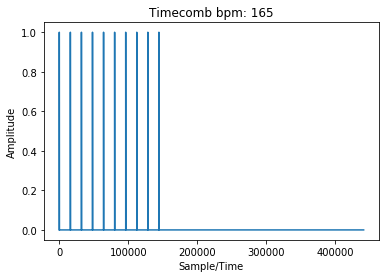

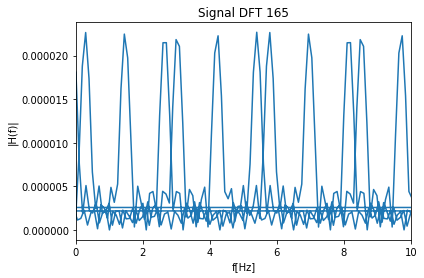

61.111111111111114


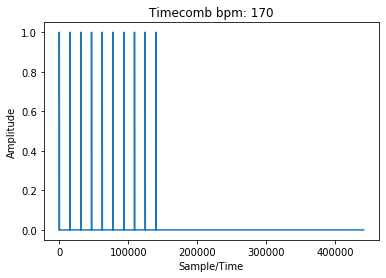

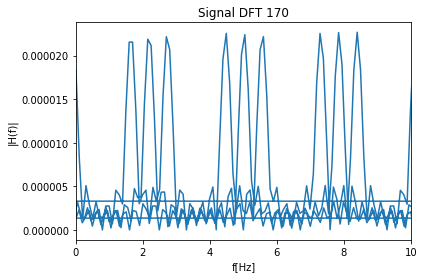

63.888888888888886


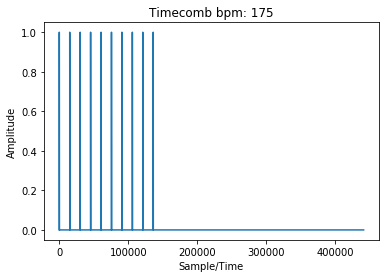

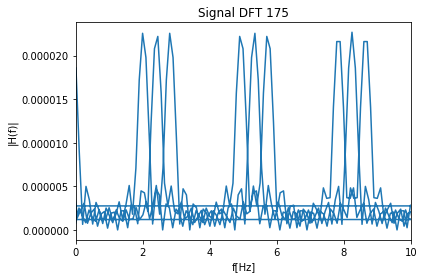

66.66666666666667


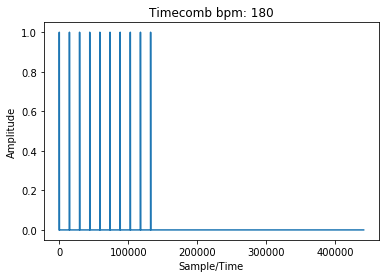

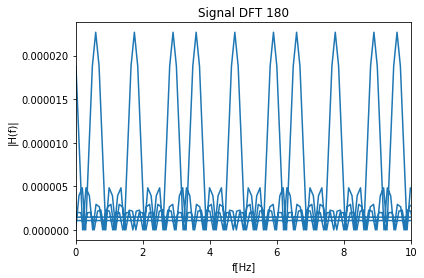

69.44444444444444


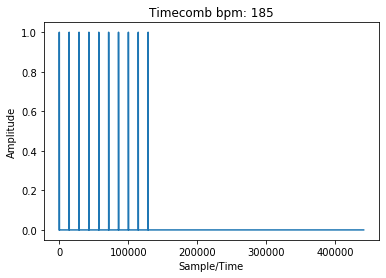

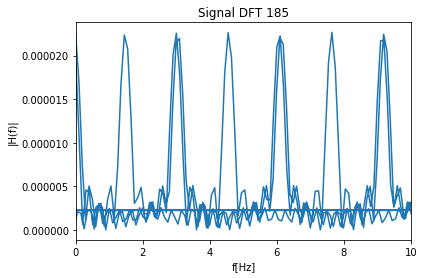

72.22222222222223


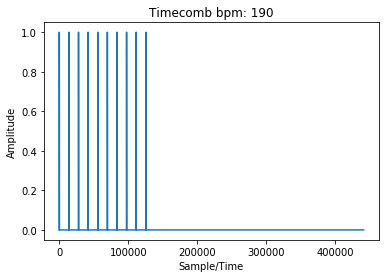

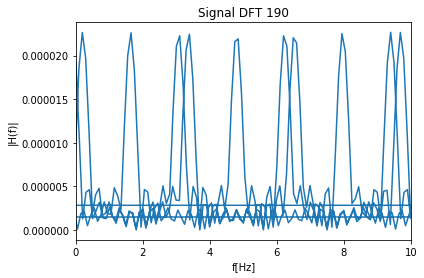

75.0


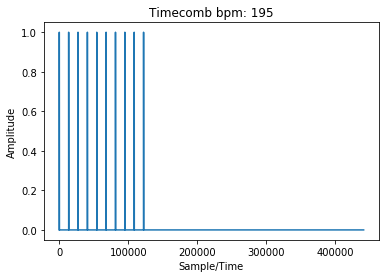

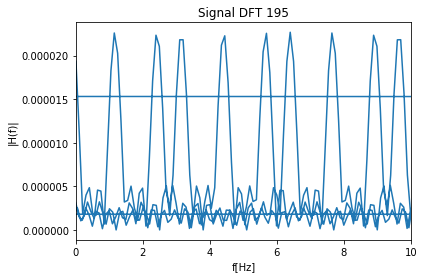

77.77777777777777


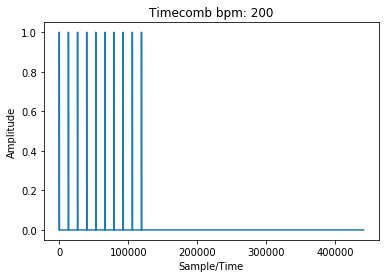

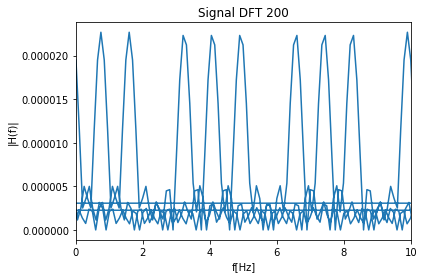

80.55555555555556


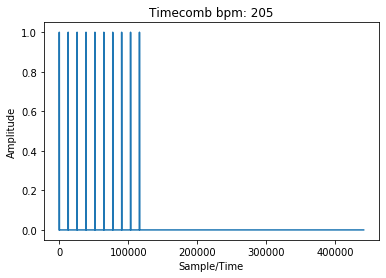

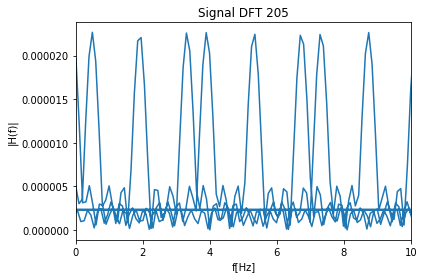

83.33333333333333


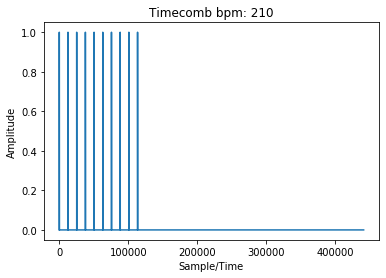

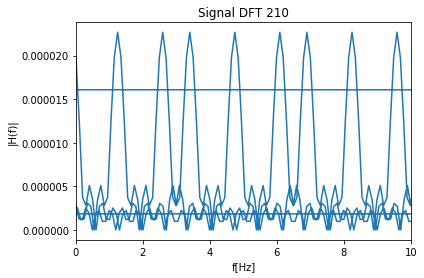

86.11111111111111


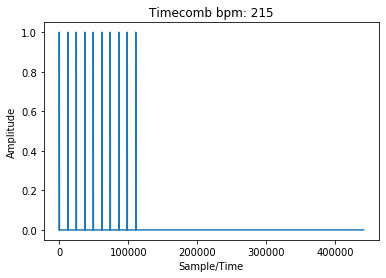

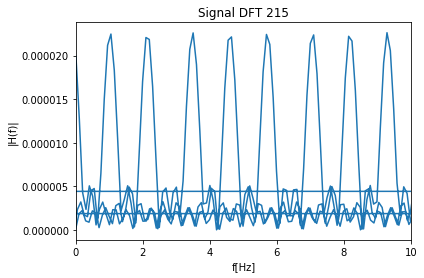

88.88888888888889


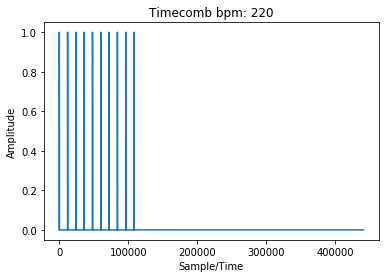

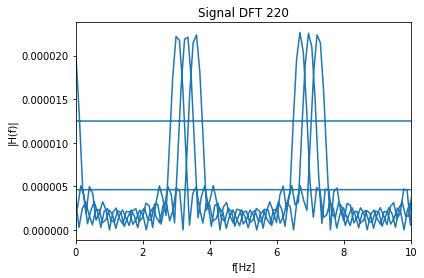

91.66666666666667


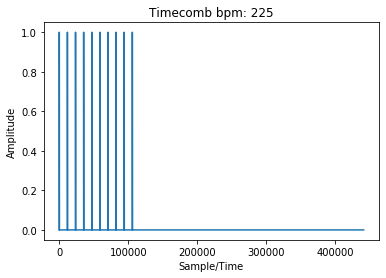

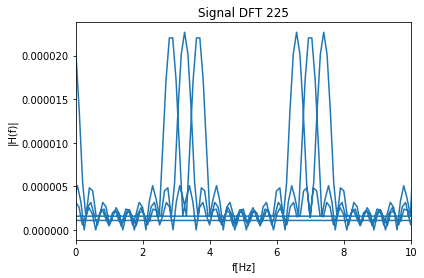

94.44444444444444


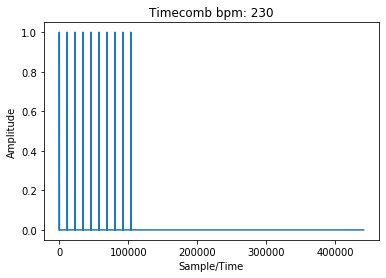

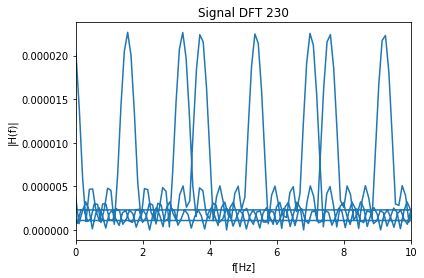

97.22222222222223


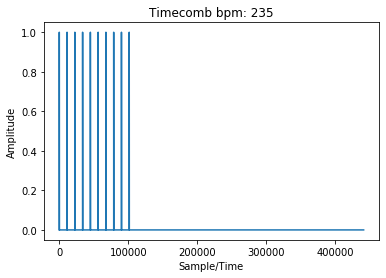

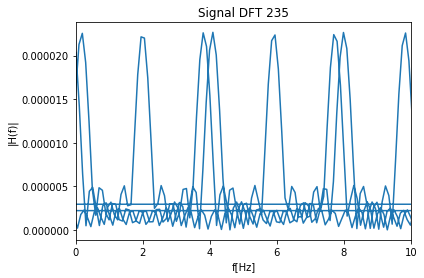

140

In [20]:
print(f'CombFiltering song {song.name}...')
plot_dictionary = PrepareDict(minBpm, maxBpm)
first = timecomb(signal=diffrected,
                              accuracy=5,
                              minBpm=minBpm,
                              maxBpm=maxBpm,
                              bandlimits=band_limits,
                              maxFreq=max_freq,
                              npulses=npulses,
                              plot_dictionary=plot_dictionary)
first

In [ ]:
song_bpm = timecomb(diffrected, 1, first - 5, first + 5, band_limits, max_freq, npulses, plot_dictionary)
DrawPlot(draw_plots, list(plot_dictionary.keys()), f"Tempo: {song.name}", "BPM", "Energy", list(plot_dictionary.values()))
song_bpm

In [ ]:
metre = detectMetre(diffrected, song_bpm, band_limits, max_freq, npulses)
metre